# Sistema de Identificação e Reconhecimento de Faces

## Etapa de Definição das Funções Auxiliares

Instalando Depedências:

In [20]:
%pip install mtcnn

Importando Libs:

In [0]:
import os
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from numpy import load
from numpy import expand_dims
from numpy import savez_compressed
from random import choice
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

Função que retorna a featurização das faces:

In [0]:
def get_embedding(model, face_pixels):
	# Escala de pixels:
	face_pixels = face_pixels.astype('float32')
	# Padronizando o valor dos pixels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transforma a face em uma amostra
	samples = expand_dims(face_pixels, axis=0)
	# retorna a featurização da amostra através do modelo
	yhat = model.predict(samples)
	return yhat[0]

 Função que carega as faces de um diretório:

In [0]:
def load_faces(directory):
	faces = list()
	# enumerate arquivos
	for filename in os.listdir(directory):
		# caminho
		path = directory + filename
		# extração da imagem
		face = extract_face(path)
		# armazenamento
		faces.append(face)
	return faces

Extrai uma face através de uma foto:

In [0]:
def extract_face(filename, required_size=(160, 160)):
	# carrega imagem 
	image = Image.open(filename)
	# conversão para RGB 
	image = image.convert('RGB')
	# conversão para um array
	pixels = asarray(image)
	# cria o detector usando os pesos padrões
	detector = MTCNN()
	# detecta a face na iagem
	results = detector.detect_faces(pixels)
	# extrai a caixa delimitadora da primeira imagem 
	x1, y1, width, height = results[0]['box']
	
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extrai a face
	face = pixels[y1:y2, x1:x2]
	# reorganiza os pixels
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

 Função que carrega todos as imagens de faces dos famosos presentes no diretório. Ressaltando que essa função utiliza a função anterior *load_faces*:

In [0]:
def load_dataset(directory):
	X, y = list(), list()
	# enumera diretorios, um por classe(ator)
	for subdir in os.listdir(directory):
		# caminho abssoluto
		path = directory + subdir + '/'
		# Pula os arquivos caso o diretório esteja vazio 
		# if not isdir(path):
		#	continue
		# carrega todos os arquivos do subdiretório
		faces = load_faces(path)
		# cria as labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# guarda as faces e labels em variáveis (dependentes e independentes)
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

## Testando a Importação dos Arquivos e Deteção das Faces:

Montando o driver com os arquivos:

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Testando as funções e montagem do driver através da extração das imagens da atriz Madonna:











1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)


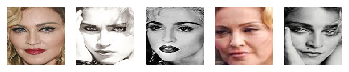

In [0]:
# specify folder to plot
folder = '/content/drive/My Drive/face_recognition/val/madonna/'
i = 1
# enumerate files
for filename in os.listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(1, 5, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

## Etapa de Detecção de Faces

Carregando todas as faces das celebridades presentes do Driver. Abaixo pode ser visto que são 41 imagens de treinamento e 10 de testes relacionadas as artigas Madonna e Mindy Kaling.

In [0]:
# conjunto de treinamento
X_train_faces, y_train_faces = load_dataset('/content/drive/My Drive/face_recognition/train/')
# conjunto de testes
X_test_faces, y_test_faces = load_dataset('/content/drive/My Drive/face_recognition/val/')

# Visualizando a forma 
print('Loaded: ', X_train_faces.shape, y_train_faces.shape, X_test_faces.shape, y_test_faces.shape)

>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
Loaded:  (41, 160, 160, 3) (41,) (10, 160, 160, 3) (10,)


## Etapa de *Featurização* das Faces:

Carregando o modelo *facenet* que contém um processo de *featurização* das faces:

In [0]:
from keras.models import load_model

model = load_model(os.path.join(os.getcwd(), '/content/drive/My Drive/face_recognition/model/facenet_keras.h5'))

# imprime a forma dos inputs e outputs do modelo:
print(model.inputs)
print(model.outputs)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[<tf.Tensor 'input_1_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Etapa de transformação das faces em features. No final temos 93 de treinamento e 25 imagens de validação contendo 128 features a respeito de 5 celebridades: Ben Afflek, Elton John, Madonna, Mindy Kaling e Jerry Seinfeld.

In [0]:
# etapa de featurização das faces usando o facenet

X_train = list()
for face_pixels in X_train_faces:
	embedding = get_embedding(model, face_pixels)
	X_train.append(embedding)
X_train = asarray(X_train)
print(X_train.shape)
# conversão de cada face no conjunto de testes 
X_test = list()
for face_pixels in X_test_faces:
	embedding = get_embedding(model, face_pixels)
	X_test.append(embedding)
X_test = asarray(X_test)
print(X_test.shape)

(41, 128)
(10, 128)


# Etapa de Classificação das Faces:

Criando um Modelo SVM para classificar as imagens.

In [0]:
# Salvando as imagens em variáveis:
y_train, y_test  = y_train_faces, y_test_faces
    
# Normalização dos input vectors
in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(X_train)
X_test = in_encoder.transform(X_test)

# Codificação das labels: 
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

# Treinamento do modelo
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Teste do modelo em uma amostra randomica no conjunto de testes 
selection = choice([i for i in range(X_test.shape[0])])
# Retornando a face em pixes para visualização
random_face_pixels = X_test_faces[selection]
# Retornando a face com as features
random_face_emb = X_test[selection]
# Retornando a classe (atriz):
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# Realizando a predição de uma face e prevendo a probabilidade
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# Retornando o Nome da face
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: mindy_kaling (99.052)
Expected: mindy_kaling


Plotando o valor e a imagem prevista junto com a probabilidade entre parênteses. Como pode ser visto o modelo conseguiu prever corretamente que a imagem é da Mindy Kaling com 92% de confiança.

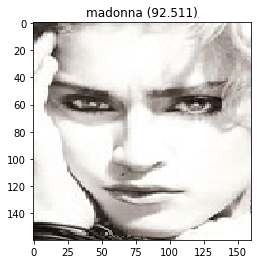

In [0]:
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()
